<a href="https://colab.research.google.com/github/ChabiMax/author_network/blob/main/Code/Question%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><strong><font color="chillipepper">Réseau Wikipédia des auteurs francophones</font></strong></center></h1>
<h5><center><font color="green">Science des réseaux sociaux et économiques <h3><center>


<center>
Maxime Chabriel, Yasmine Houri, Mathis Sansu  

ENSAE 2022
</center>

<h2><center><strong><font color="chillipepper">Analyses</font></strong></center></h2>

# Packages

In [158]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import pickle as pkl

# Données

In [159]:
# Lien du repository GitHub pour récupérer les données
git_url = "https://raw.githubusercontent.com/ChabiMax/author_network/main/"
data = pd.read_pickle(git_url+'/Data/raw_data.pkl')

In [160]:
# Passage du dictionnaire sous forme de dataframe
df = pd.DataFrame(data).T
df.head()

,name,link,date_mort,date_naissance,taille_html_article,network_interauteur,poids_liens_interauteur,genres_mentionnes,type,contemporain,poids_contempo_diff_naissance,poids_contempo_annees_communes,auteurs_du_genre,debut_genre,fin_genre
0,Turold,https://fr.wikipedia.org/wiki/Turold,NaN,NaN,73673,[],[],[],auteur,[],[],[],NaN,NaN,NaN
1,Philippe de Thaon,https://fr.wikipedia.org/wiki/Philippe_de_Thaon,NaN,NaN,68910,[],[],[],auteur,[],[],[],NaN,NaN,NaN
2,Benoît de Sainte-Maure,https://fr.wikipedia.org/wiki/Beno%C3%AEt_de_S...,NaN,NaN,83269,[4],[1],[1627],auteur,[],[],[],NaN,NaN,NaN
3,Jean Bodel,https://fr.wikipedia.org/wiki/Jean_Bodel,1165,NaN,73274,"[10, 22]","[1, 1]","[1663, 1691, 1604]",auteur,[],[],[],NaN,NaN,NaN
4,Wace,https://fr.wikipedia.org/wiki/Wace,1174,1100,99714,[6],[2],"[1591, 1662]",auteur,"[5, 6, 7, 9, 10, 11]","[10, 30, 50, 60, 60, 60]","[52, 44, 24, 14, 14, 14]",NaN,NaN,NaN


# Réseau interauteurs : hyperliens auteurs sur les pages auteurs

## Table des liens

In [161]:
id = 0 # Initialisation
id_link = id 
link_table = dict()

for source in df.index :
  if df.iloc[id]['type'] == "auteur":
    for i in range(len(df.iloc[id]['network_interauteur'])):
      target = df.iloc[id]['network_interauteur'][i]
      link_table[id_link] = {'source' : source, 'target' : target}
      weight = df.iloc[id]['poids_liens_interauteur'][i]
      link_table[id_link]['weight'] = weight
      if target in df.iloc[id]['contemporain'] :
        index_contemp = df.iloc[id]['contemporain'].index(target)
        contemporain = 1
        diff_naissance = df.iloc[id]['poids_contempo_diff_naissance'][index_contemp]
        annees_communes = df.iloc[id]['poids_contempo_annees_communes'][index_contemp]
      else:
        contemporain = 0
        diff_naissance = 0
        annees_communes = 0
      link_table[id_link]['contemporain'] = contemporain
      link_table[id_link]['diff_naissance'] = diff_naissance
      link_table[id_link]['annees_communes'] = annees_communes
      id_link +=1
    id += 1

In [162]:
edge_links = pd.DataFrame(link_table).T
edge_links.head()

,source,target,weight,contemporain,diff_naissance,annees_communes
0,2,4,1,0,0,0
1,3,10,1,0,0,0
2,3,22,1,0,0,0
3,4,6,2,1,30,44
4,6,4,1,1,30,44


## Réseau complet

In [163]:
# Graph orienté
GraphAuthorLink = nx.from_pandas_edgelist(edge_links, 'source', 'target', edge_attr = True, create_using=nx.DiGraph())

In [164]:
print(nx.info(GraphAuthorLink))

DiGraph with 1250 nodes and 13021 edges


In [165]:
# match nodes of graph with attributes of nodes
df_node = df[df["type"] == "auteur"]
df_node['Node'] = df_node.index
NodeData = df_node.set_index('Node').to_dict('index').items()
GraphAuthorLink.add_nodes_from(NodeData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [166]:
print(nx.info(GraphAuthorLink))

DiGraph with 1584 nodes and 13021 edges


## Caractéristiques

In [167]:
# Removing isolates
GraphAuthorLink_withoutiso = GraphAuthorLink
GraphAuthorLink_withoutiso.remove_nodes_from(list(nx.isolates(GraphAuthorLink_withoutiso)))

In [169]:
# Nombre de noeuds
N_nodes = GraphAuthorLink_withoutiso.number_of_nodes()
print(N_nodes)

1250


In [170]:
# Liens sortants
print(GraphAuthorLink_withoutiso.out_degree())
# Liens entrants
print(GraphAuthorLink_withoutiso.in_degree())
# Liens totaux
print(GraphAuthorLink_withoutiso.degree())

[(2, 1), (4, 1), (3, 2), (10, 0), (22, 0), (6, 2), (732, 65), (7, 1), (11, 3), (18, 3), (21, 3), (14, 5), (13, 0), (1, 0), (102, 0), (15, 2), (17, 1), (24, 3), (19, 3), (729, 46), (733, 58), (779, 33), (39, 2), (25, 1), (26, 1), (29, 1), (35, 3), (30, 1), (198, 18), (31, 3), (37, 3), (20, 0), (34, 4), (443, 18), (375, 24), (913, 40), (38, 1), (51, 2), (40, 8), (73, 12), (523, 13), (665, 26), (326, 25), (41, 4), (98, 1), (50, 1), (42, 1), (44, 2), (60, 3), (45, 1), (46, 4), (56, 22), (1255, 3), (1273, 22), (47, 2), (48, 1), (59, 3), (58, 1), (52, 1), (53, 1), (565, 17), (197, 3), (70, 31), (213, 11), (376, 69), (402, 21), (431, 7), (515, 43), (422, 32), (480, 30), (391, 21), (502, 27), (680, 15), (731, 23), (672, 26), (978, 43), (67, 8), (64, 2), (248, 51), (366, 14), (62, 1), (66, 2), (71, 6), (93, 18), (92, 5), (68, 2), (69, 1), (79, 4), (65, 0), (1004, 15), (601, 16), (104, 2), (199, 42), (203, 5), (171, 3), (329, 36), (339, 32), (387, 28), (424, 20), (355, 29), (570, 27), (572, 8), 

In [171]:
# Densité
print(nx.density(GraphAuthorLink_withoutiso))
# Réciprocité globale
print(nx.reciprocity(GraphAuthorLink_withoutiso))
# Réciprocité locale
print(nx.reciprocity(GraphAuthorLink_withoutiso, nodes = GraphAuthorLink_withoutiso.nodes))
# Transitivité
print(nx.transitivity(GraphAuthorLink_withoutiso)) # Coeff de cluster global
print(nx.clustering(GraphAuthorLink_withoutiso)) # Coeff de cluster local
print(nx.average_clustering(GraphAuthorLink_withoutiso)) # Coeff de cluster local moyen

0.008340112089671737
0.5131710314107979
{2: 0.0, 4: 0.5, 3: 0.0, 10: 0.0, 22: 0.0, 6: 0.2222222222222222, 732: 0.6413043478260869, 7: 0.0, 11: 0.6666666666666666, 18: 0.8, 21: 0.8, 14: 0.0, 13: 0.0, 1: 0.0, 102: 0.0, 15: 0.0, 17: 0.6666666666666666, 24: 0.4444444444444444, 19: 0.0, 729: 0.460431654676259, 733: 0.46153846153846156, 779: 0.7792207792207793, 39: 0.8, 25: 0.0, 26: 0.0, 29: 1.0, 35: 0.6666666666666666, 30: 0.0, 198: 0.3, 31: 0.6666666666666666, 37: 0.2857142857142857, 20: 0.0, 34: 0.4, 443: 0.5660377358490566, 375: 0.44155844155844154, 913: 0.8089887640449438, 38: 0.0, 51: 0.5, 40: 0.2, 73: 0.3333333333333333, 523: 0.3333333333333333, 665: 0.10526315789473684, 326: 0.6774193548387096, 41: 0.0, 98: 0.0, 50: 0.0, 42: 0.0, 44: 0.0, 60: 0.0, 45: 0.0, 46: 0.25, 56: 0.21739130434782608, 1255: 0.0, 1273: 0.35, 47: 0.0, 48: 0.0, 59: 0.4, 58: 1.0, 52: 0.0, 53: 0.0, 565: 0.26666666666666666, 197: 0.3076923076923077, 70: 0.21818181818181817, 213: 0.2962962962962963, 376: 0.50925925925

In [172]:
# Cliques
print(list(nx.find_cliques(GraphAuthorLink_withoutiso.to_undirected())))
# Connectivité
print(nx.is_connected(GraphAuthorLink_withoutiso.to_undirected()))
# Connectivité faible
print(nx.is_weakly_connected(GraphAuthorLink_withoutiso))

[[0, 1090], [1, 14], [2, 4, 14], [3, 56], [3, 10], [3, 22], [4, 6], [6, 929], [6, 11, 18, 21], [6, 1524], [6, 1525], [6, 732], [7, 11], [7, 15], [13, 14], [14, 102], [15, 25], [15, 22], [17, 24, 96], [19, 729, 779, 733], [20, 56], [20, 31], [22, 24], [22, 891], [24, 50], [24, 67], [24, 39, 40], [26, 732], [29, 35], [30, 198], [31, 35, 37], [31, 1524], [34, 913], [34, 35], [34, 443], [34, 375], [35, 42], [35, 44], [37, 40], [37, 198], [37, 46, 56], [38, 51], [39, 41], [40, 326, 523], [40, 73], [40, 792, 732], [40, 665], [41, 72, 73], [41, 50], [41, 67, 73], [41, 67, 98], [41, 47], [44, 60], [45, 198], [46, 56, 817], [46, 56, 1445], [46, 1273], [46, 900], [46, 1255], [47, 56], [48, 59], [51, 73], [51, 58], [52, 60], [53, 198], [59, 56], [59, 67, 64], [60, 56], [60, 366, 248], [61, 99], [62, 73], [63, 72], [64, 73, 67], [65, 72, 70], [65, 99], [65, 95], [66, 73, 71], [67, 73, 93], [67, 73, 70], [67, 92, 93], [69, 70], [71, 147], [71, 93, 104, 73], [71, 93, 104, 92], [71, 93, 84, 73], [71,

In [173]:
# Centralité de degré
print(nx.degree_centrality(GraphAuthorLink_withoutiso))
# Centralité de degré entrant
print(nx.in_degree_centrality(GraphAuthorLink_withoutiso))
# Centralité de degré sortant
print(nx.out_degree_centrality(GraphAuthorLink_withoutiso))
# In-edge centralité de vecteur propre
print(nx.eigenvector_centrality(GraphAuthorLink_withoutiso))
# Out-edge centralité de vecteur propre
print(nx.eigenvector_centrality(GraphAuthorLink_withoutiso.reverse()))
# Centralité de distance (inward)
print(nx.closeness_centrality(GraphAuthorLink_withoutiso))
# Centralité de distance (outward)
print(nx.closeness_centrality(GraphAuthorLink_withoutiso.reverse()))
# Centralité betweenness
print(nx.betweenness_centrality(GraphAuthorLink_withoutiso))

{2: 0.0016012810248198558, 4: 0.0032025620496397116, 3: 0.0024019215372297837, 10: 0.0008006405124099279, 22: 0.0032025620496397116, 6: 0.007205764611689351, 732: 0.14731785428342672, 7: 0.0016012810248198558, 11: 0.004803843074459567, 18: 0.0040032025620496394, 21: 0.0040032025620496394, 14: 0.0040032025620496394, 13: 0.0008006405124099279, 1: 0.0008006405124099279, 102: 0.0008006405124099279, 15: 0.0024019215372297837, 17: 0.0024019215372297837, 24: 0.007205764611689351, 19: 0.0024019215372297837, 729: 0.11128903122497998, 733: 0.07285828662930344, 779: 0.06164931945556445, 39: 0.0040032025620496394, 25: 0.0008006405124099279, 26: 0.0008006405124099279, 29: 0.0016012810248198558, 35: 0.007205764611689351, 30: 0.0008006405124099279, 198: 0.04803843074459567, 31: 0.004803843074459567, 37: 0.005604483586869495, 20: 0.0016012810248198558, 34: 0.0040032025620496394, 443: 0.04243394715772618, 375: 0.06164931945556445, 913: 0.07125700560448359, 38: 0.0008006405124099279, 51: 0.0032025620496

# Question 2 - Baseline


(array([ 3.,  1.,  0.,  6.,  0.,  5.,  0.,  0.,  1.,  4.,  3.,  1.,  0.,
         2.,  4.,  1.,  0.,  8.,  9.,  5.,  2.,  3., 15.,  6.,  5.,  0.,
         1.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  1.,  5.,  7.,  4.,  2.,
        12.]),
 array([1100.0, 1121.825, 1143.65, 1165.475, 1187.3, 1209.125, 1230.95,
        1252.775, 1274.6, 1296.425, 1318.25, 1340.075, 1361.9, 1383.725,
        1405.55, 1427.375, 1449.2, 1471.025, 1492.85, 1514.675, 1536.5,
        1558.325, 1580.15, 1601.975, 1623.8, 1645.625, 1667.4499999999998,
        1689.275, 1711.1, 1732.925, 1754.75, 1776.5749999999998, 1798.4,
        1820.225, 1842.05, 1863.875, 1885.6999999999998, 1907.525, 1929.35,
        1951.175, 1973.0], dtype=object),
 <a list of 40 Patch objects>)

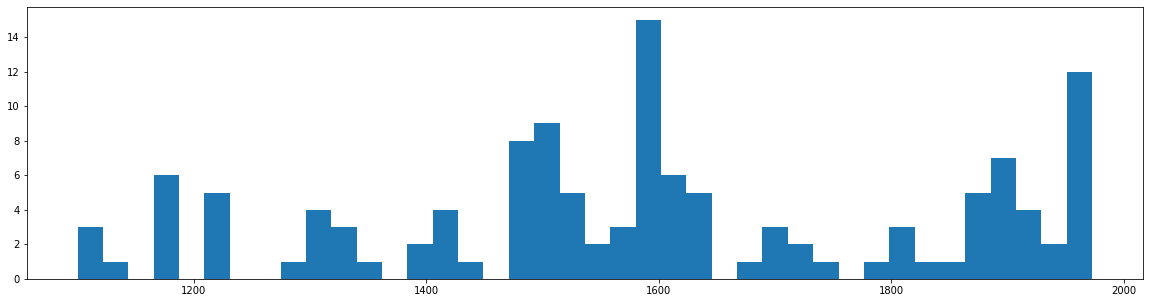

In [174]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

df_genre = df[df['type'] == 'genre']
df_genre = df_genre[df_genre['debut_genre'] != 9999]

plt.hist(df_genre['debut_genre'], bins = 40)


In [175]:
from tqdm import tqdm_notebook

# Year subsets and building metrics
df_auteurs = df[df['type'] == 'auteur']
measure_list = {}
for année in tqdm_notebook(reversed(range(1000, 2025, 5))) :
  selected_nodes = [node for node, value in GraphAuthorLink.nodes(data=True) if (value['date_mort'] >= année) & (value['date_naissance'] <= année)] 
  subgraph = GraphAuthorLink.subgraph(selected_nodes)
  # if len(selected_nodes) > 10 :
  if len(selected_nodes) > 1 :
    try :
      subgraph_undirected = subgraph.to_undirected()
      subgraph_undirected_connected_components = sorted(nx.connected_components(subgraph_undirected), key=len, reverse=True)
      subgraph_undirected_giant = subgraph.subgraph(subgraph_undirected_connected_components[0])
      measure_list[année] = {'graph_size' : subgraph.number_of_nodes(),
                             'graph_giant_size' : subgraph_undirected_giant.number_of_nodes(),
                             'density_undirected' : nx.density(subgraph_undirected),
                             'density_directed' : nx.density(subgraph), 
                             'density_giant' : nx.density(subgraph_undirected_giant),
                             'average_clustering' : nx.average_clustering(subgraph_undirected_giant),
                             'transitivity' : nx.transitivity(subgraph)}
    except : 
      pass

annee_data = pd.DataFrame(measure_list).T
annee_data['annee'] = annee_data.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

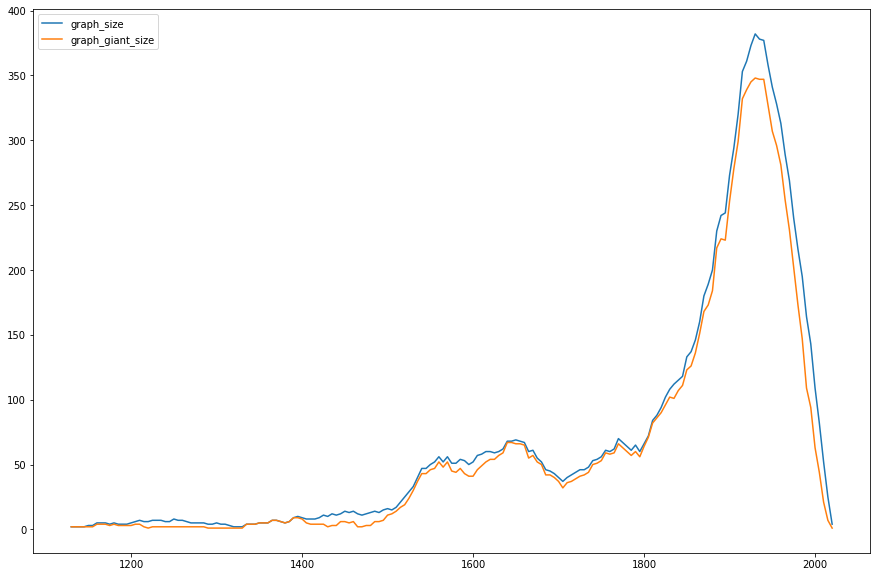

In [176]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['graph_size'], label = 'graph_size')
plt.plot(annee_data['annee'], annee_data['graph_giant_size'], label = 'graph_giant_size')
plt.legend()
plt.show()

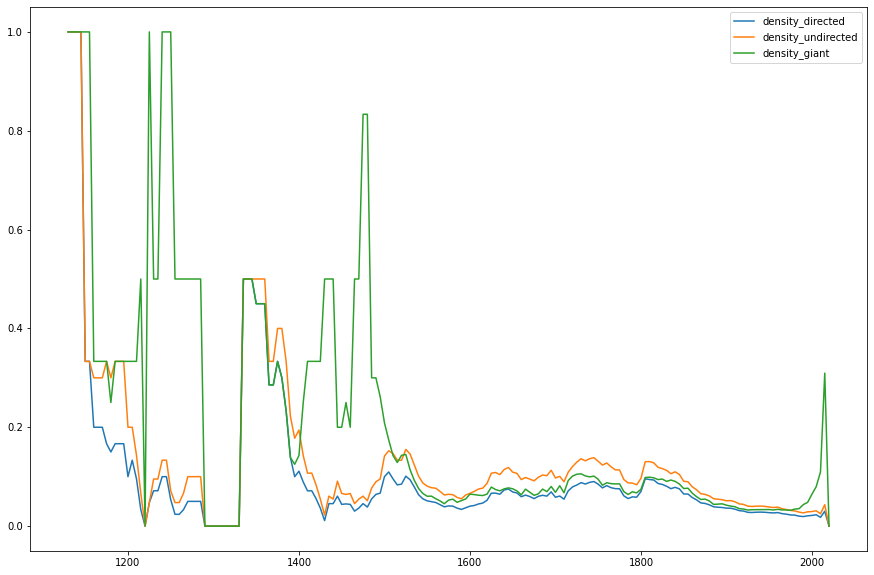

In [177]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['density_directed'], label = 'density_directed')
plt.plot(annee_data['annee'], annee_data['density_undirected'], label = 'density_undirected')
plt.plot(annee_data['annee'], annee_data['density_giant'], label = 'density_giant')
plt.legend()
plt.show()

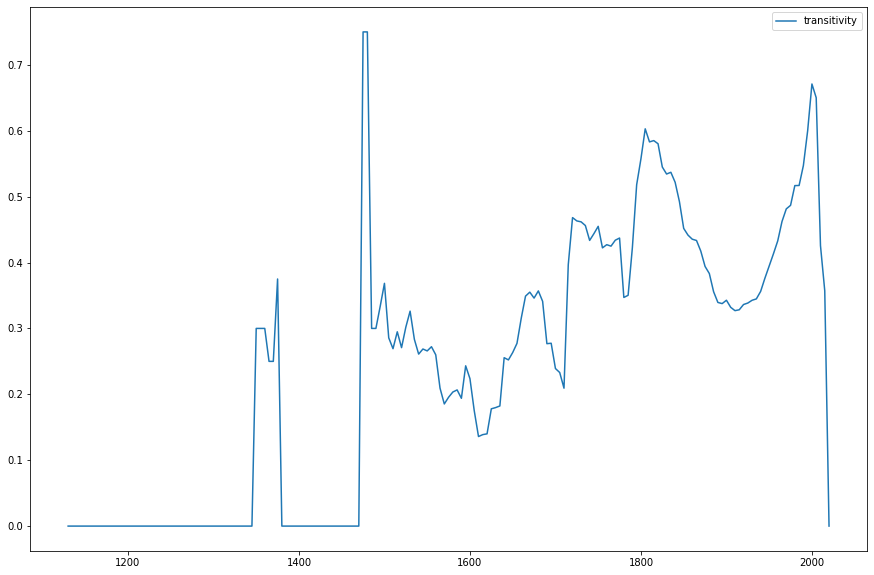

In [178]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['transitivity'], label = 'transitivity')
plt.legend()
plt.show()

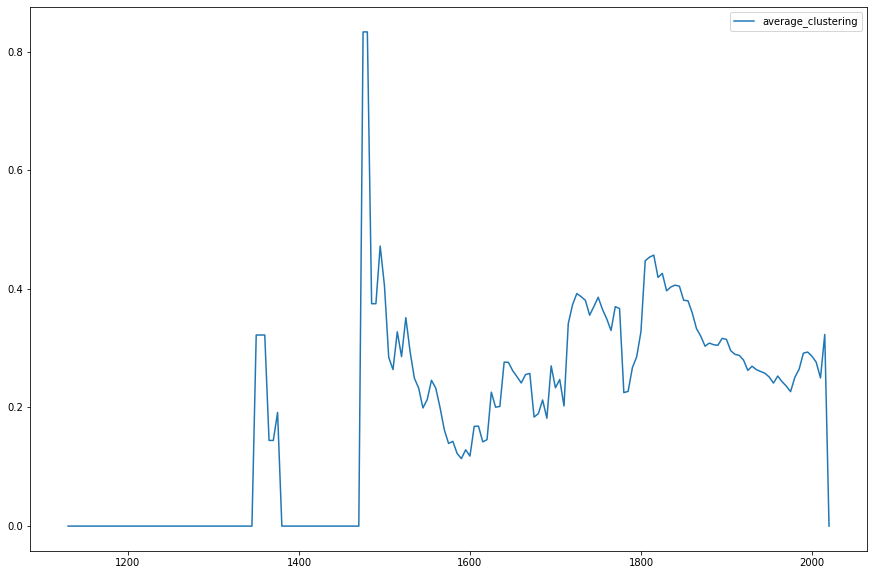

In [179]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['average_clustering'], label = 'average_clustering')
plt.legend()
plt.show()

Comparaison

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


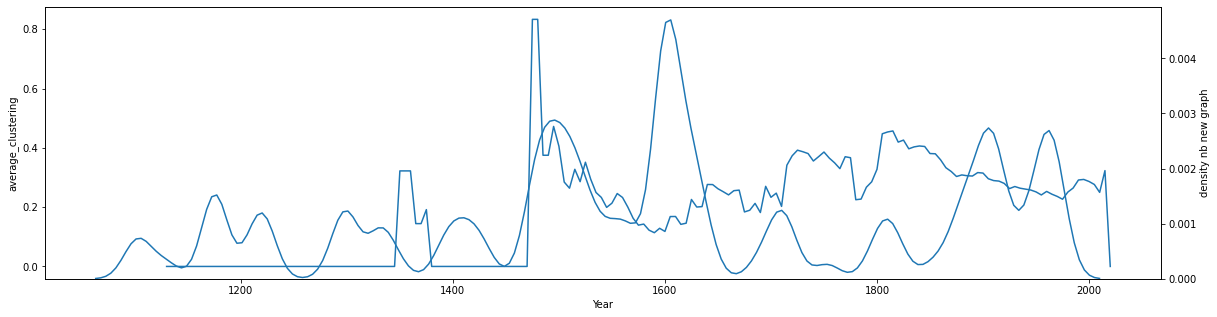

In [180]:
import seaborn as sns
import numpy as np

plt.rcParams['figure.figsize'] = [20, 5]

df_genre = df[df['type'] == 'genre']
df_genre = df_genre[df_genre['debut_genre'] != 9999]

x = np.arange(0, 10, 0.1)
y1 = 0.05 * x**2
y2 = -1 *y1

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(annee_data['annee'], annee_data['average_clustering'], label = 'average_clustering')
sns.kdeplot(df_genre['debut_genre'], bw=0.05, ax = ax2)

ax1.set_xlabel('Year')
ax1.set_ylabel('average_clustering')
ax2.set_ylabel('density nb new graph')

plt.show()



# Question 2 - Subset taille de page

(array([  1.,   0.,   0.,   0.,   0.,   0.,   4.,  25.,  55., 102., 115.,
        138., 104., 140., 114., 115., 101.,  82.,  75.,  59.,  64.,  54.,
         47.,  25.,  35.,  24.,  17.,  24.,  17.,   7.,   8.,   1.,   7.,
          2.,   5.,  10.,   4.,   1.,   0.,   2.]),
 array([ 9.99729661, 10.09837902, 10.19946143, 10.30054384, 10.40162625,
        10.50270866, 10.60379107, 10.70487348, 10.80595589, 10.9070383 ,
        11.00812071, 11.10920312, 11.21028553, 11.31136794, 11.41245035,
        11.51353276, 11.61461518, 11.71569759, 11.81678   , 11.91786241,
        12.01894482, 12.12002723, 12.22110964, 12.32219205, 12.42327446,
        12.52435687, 12.62543928, 12.72652169, 12.8276041 , 12.92868651,
        13.02976892, 13.13085133, 13.23193374, 13.33301615, 13.43409857,
        13.53518098, 13.63626339, 13.7373458 , 13.83842821, 13.93951062,
        14.04059303]),
 <a list of 40 Patch objects>)

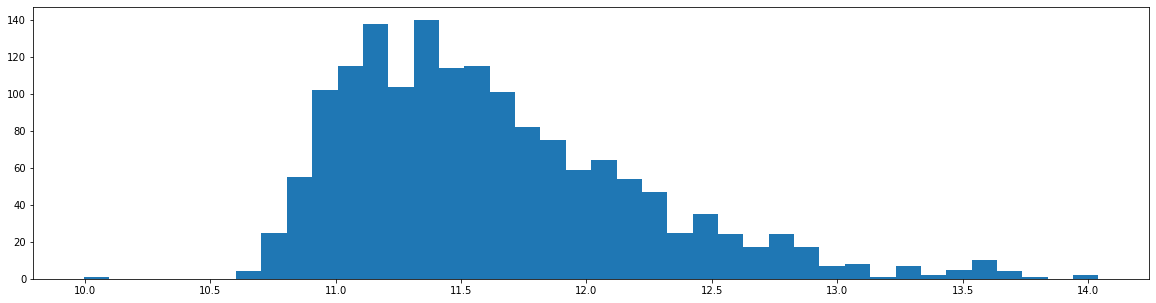

In [181]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.hist(np.log(pd.to_numeric(df_auteurs['taille_html_article'])), bins = 40)

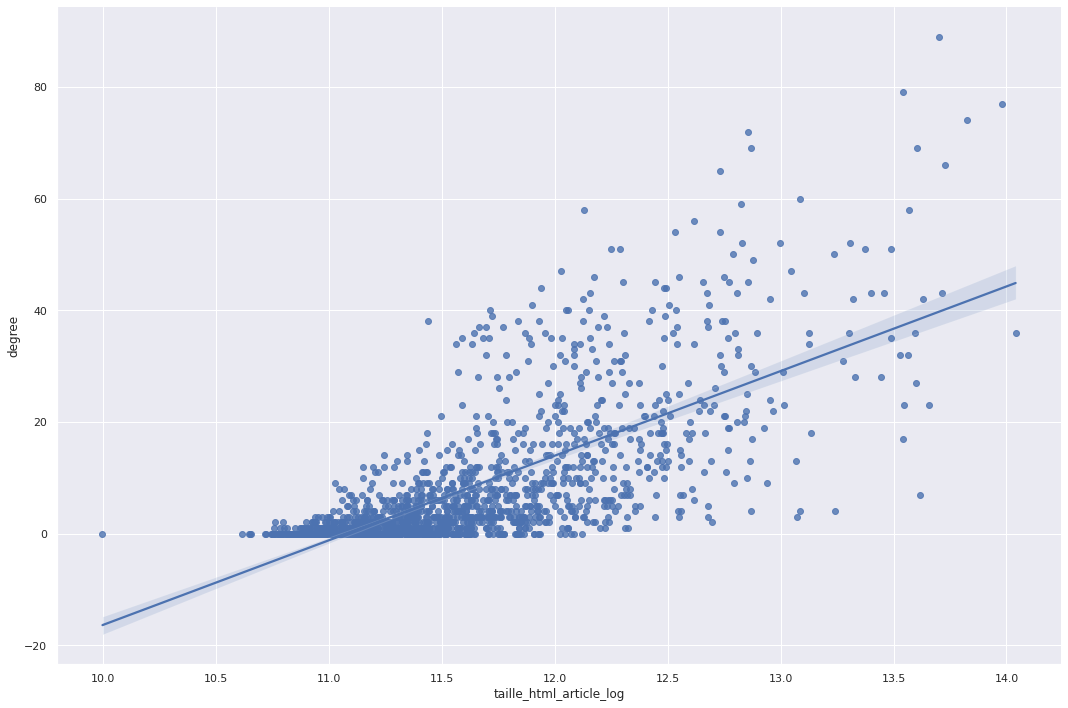

In [337]:
plt.rcParams['figure.figsize'] = [20, 5]

# nx.get_node_attributes(GraphAuthorLink, 'taille_html_article')
tailles = nx.get_node_attributes(GraphAuthorLink, 'taille_html_article')
tailles = pd.DataFrame(tailles.items())
degrees = dict()
for (node, val) in GraphAuthorLink.out_degree() :
  degrees[node] = val
degrees = pd.DataFrame(degrees.items())
degree_tailles_df = pd.merge(degrees, tailles, on=0, how='outer')
degree_tailles_df.columns = ['Id', 'degree', 'taille_html_article']
degree_tailles_df['taille_html_article_log'] = np.log(degree_tailles_df['taille_html_article'])
sns.lmplot(y = "degree", x = "taille_html_article_log", data = degree_tailles_df, height = 10, aspect = 15/10)

In [352]:
import statsmodels.formula.api as smf
model = smf.ols("degree ~ taille_html_article_log -1", data = degree_tailles_df)
model = model.fit()
coeff_reg = model.params['taille_html_article_log']
# intercept_reg = model.params['Intercept']

In [378]:
from tqdm import tqdm_notebook

df['poids_liens_interauteur2'] = None
min_true_degrees = 0
for auteur in tqdm_notebook(df['name'][df['type'] == 'auteur']) :
  idx = int(df[df['name'] == auteur].index[0])
  poids = df[df['name'] == auteur]['poids_liens_interauteur']
  poids = list(poids)[0]
  if poids != [] :
    true_degree = list(len(df[df['name'] == auteur]['poids_liens_interauteur']) - coeff_reg*np.log(pd.to_numeric(df[df['name'] == auteur]['taille_html_article'])))[0]
    min_true_degrees = min(min_true_degrees, true_degree)

for auteur in tqdm_notebook(df['name'][df['type'] == 'auteur']) :
  idx = int(df[df['name'] == auteur].index[0])
  poids = df[df['name'] == auteur]['poids_liens_interauteur']
  poids = list(poids)[0]
  if poids != [] :
    true_degree = list(len(df[df['name'] == auteur]['poids_liens_interauteur']) - coeff_reg*np.log(pd.to_numeric(df[df['name'] == auteur]['taille_html_article'])))[0] - min_true_degrees + 0.1
    normalisation_coeff = true_degree / sum(poids)
    poids = [poid * normalisation_coeff for poid in poids]
  else :
    poids = []
  df.at[idx,'poids_liens_interauteur2'] = poids


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/1584 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/1584 [00:00<?, ?it/s]

In [184]:
from tqdm import tqdm_notebook

# Year subsets and building metrics
df_auteurs = df
measure_list = {}
for année in tqdm_notebook(reversed(range(1000, 2025, 5))) :
  selected_nodes = [node for node, value in GraphAuthorLink.nodes(data=True) if (value['date_mort'] >= année) & (value['date_naissance'] <= année)] 
  subgraph = GraphAuthorLink.subgraph(selected_nodes)
  # if len(selected_nodes) > 10 :
  if len(selected_nodes) > 1 :
    try :
      subgraph_undirected = subgraph.to_undirected()
      subgraph_undirected_connected_components = sorted(nx.connected_components(subgraph_undirected), key=len, reverse=True)
      subgraph_undirected_giant = subgraph.subgraph(subgraph_undirected_connected_components[0])
      measure_list[année] = {'graph_size' : subgraph.number_of_nodes(),
                             'graph_giant_size' : subgraph_undirected_giant.number_of_nodes(),
                             'density_undirected' : nx.density(subgraph_undirected),
                             'density_directed' : nx.density(subgraph), 
                             'density_giant' : nx.density(subgraph_undirected_giant),
                             'average_clustering' : nx.average_clustering(subgraph_undirected_giant),
                             'transitivity' : nx.transitivity(subgraph)}
    except : 
      pass

annee_data = pd.DataFrame(measure_list).T
annee_data['annee'] = annee_data.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

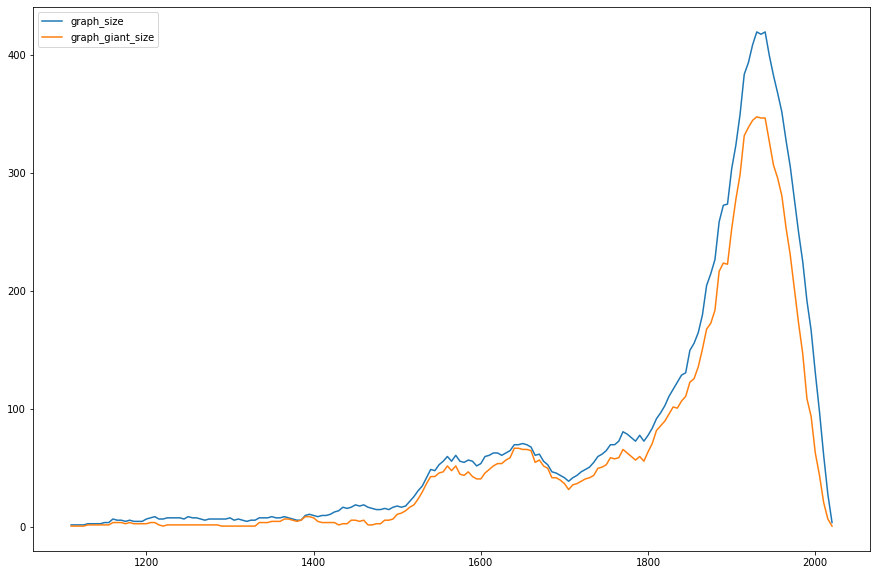

In [185]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['graph_size'], label = 'graph_size')
plt.plot(annee_data['annee'], annee_data['graph_giant_size'], label = 'graph_giant_size')
plt.legend()
plt.show()

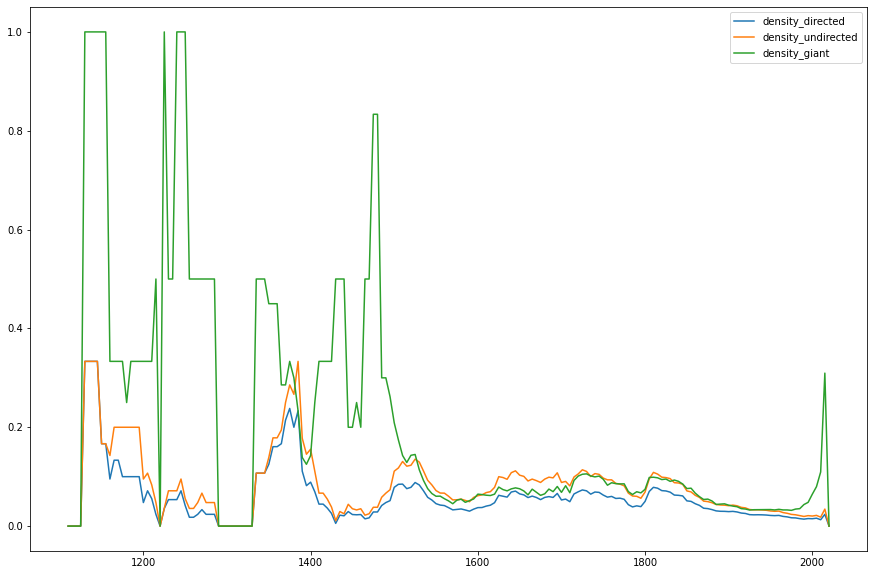

In [186]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['density_directed'], label = 'density_directed')
plt.plot(annee_data['annee'], annee_data['density_undirected'], label = 'density_undirected')
plt.plot(annee_data['annee'], annee_data['density_giant'], label = 'density_giant')
plt.legend()
plt.show()

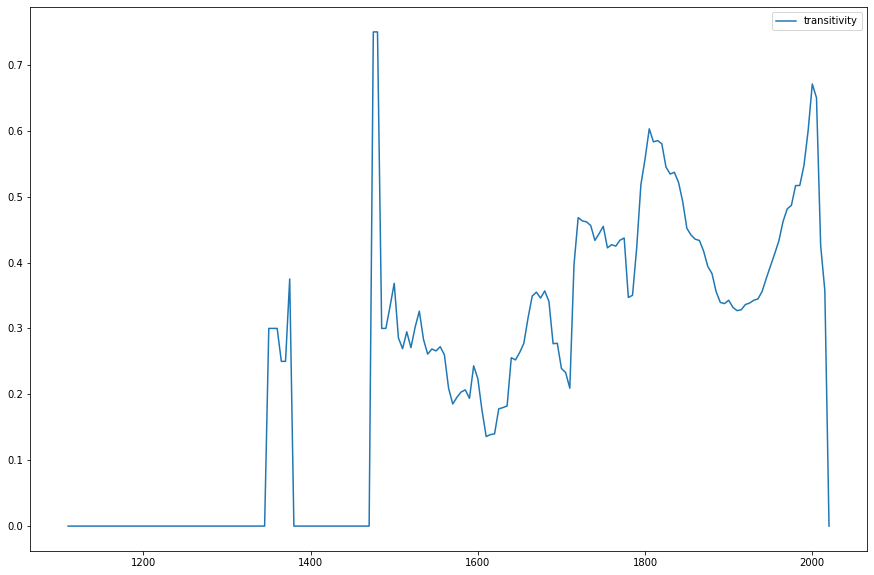

In [187]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['transitivity'], label = 'transitivity')
plt.legend()
plt.show()

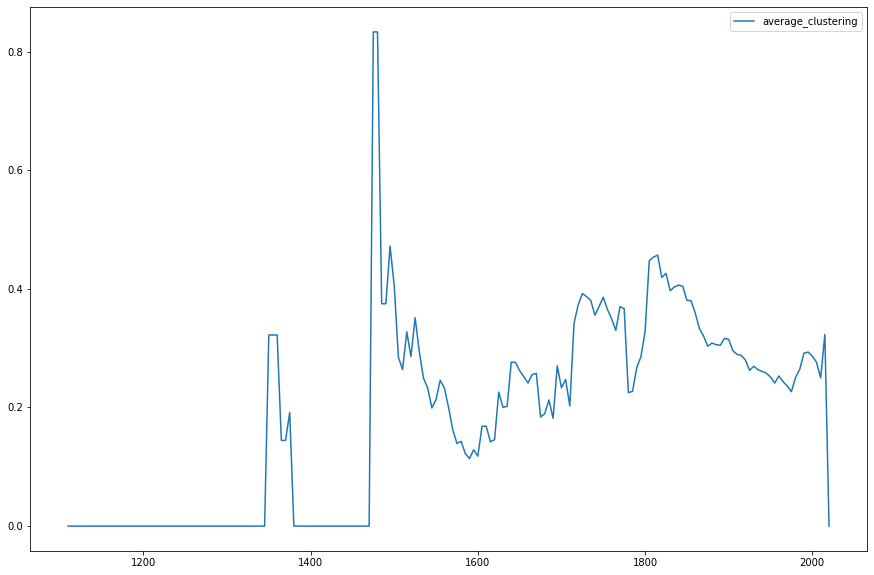

In [188]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['average_clustering'], label = 'average_clustering')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


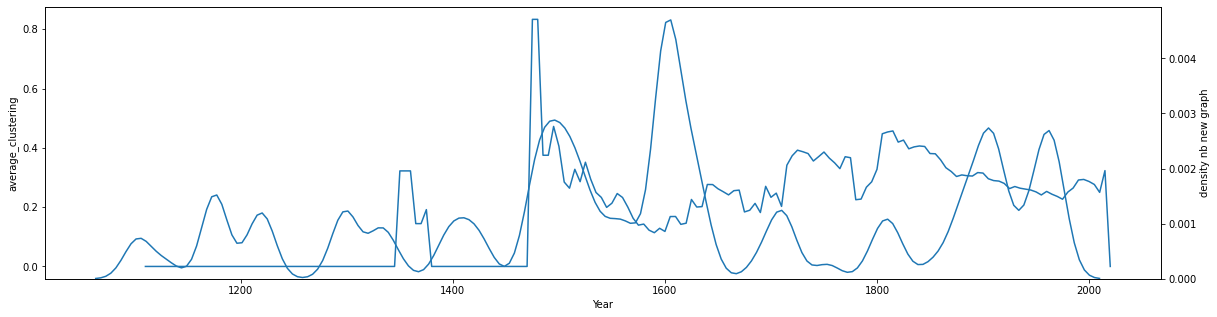

In [189]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [20, 5]

df_genre = df[df['type'] == 'genre']
df_genre = df_genre[df_genre['debut_genre'] != 9999]

x = np.arange(0, 10, 0.1)
y1 = 0.05 * x**2
y2 = -1 *y1

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(annee_data['annee'], annee_data['average_clustering'], label = 'average_clustering')
sns.kdeplot(df_genre['debut_genre'], bw=0.05, ax = ax2)

ax1.set_xlabel('Year')
ax1.set_ylabel('average_clustering')
ax2.set_ylabel('density nb new graph')

plt.show()

